# Demographics & Statistics

In [1]:
import json
import os
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [ ]:
%cd ..

In [3]:
config_file = "src/configs/0_control.json"
with open(config_file) as f:
    config = json.load(f)

In [4]:
patient_df = pd.read_csv("data/processed/patient_df.csv")
train_loc = config["train_loc"]
targets = {"Control": [0], "Pneumonia": [1,2], "Wheezing Disorders": [3,4], "Bronchiolitis": [5]}

In [5]:
unknown_diagnoses_file = "data/raw/canonical_data/pediatric_studies/unknown_diagnoses.json"
with open(unknown_diagnoses_file) as f:
    print("Removing patients with unknown diagnosis")
    unknown_diagnoses = json.load(f)
    # Label patients with unknown diagnosis (either Obstructive Bronchitis or Bronchiolitis)
    patient_df.loc[patient_df.patient.isin(unknown_diagnoses), "diagnosis"] = 6
    # Remove patients with multiple diagnoses
    patient_df = patient_df[~patient_df.multilabel]
    patient_df

Removing patients with unknown diagnosis


In [6]:
diagnosis_dist = patient_df.groupby(["diagnosis", "location"])["patient"]\
                           .count()\
                           .reset_index()\
                           .pivot(index="diagnosis", columns="location", values="patient")\
                           .fillna(0.)\
                           .astype(int)
    
diagnosis_dist = diagnosis_dist.assign(Total_Diagnosis=diagnosis_dist.values.sum(axis=1))
cols = ["GVA", "POA", "DKR", "MAR", "RBA", "YAO", "Total_Diagnosis"]
diagnosis_dist = diagnosis_dist[cols]
diagnosis_dist = diagnosis_dist.append({c: v for c, v in zip(cols, diagnosis_dist.values.sum(axis=0))}, ignore_index=True)
diagnosis_dist.index = ["Control", "Viral Pneumonia", "Bacterial Pneumonia", "Obstructive Bronchitis", "Asthma", "Bronchiolitis", "Unknown", "Total_Site"]

diagnosis_dist

,GVA,POA,DKR,MAR,RBA,YAO,Total_Diagnosis
Control,23,80,17,2,30,13,165
Viral Pneumonia,23,32,5,0,0,42,102
Bacterial Pneumonia,4,6,0,0,0,2,12
Obstructive Bronchitis,22,4,0,0,4,6,36
Asthma,45,17,8,1,14,0,85
Bronchiolitis,4,91,1,8,0,16,120
Unknown,0,53,0,0,0,0,53
Total_Site,121,283,31,11,48,79,573


## Population Statistics

In [7]:
from os import listdir
from os.path import join, isfile, isdir

In [8]:
base_folder = "data/raw/canonical_data/pediatric_studies/features"

In [9]:
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = data[~data.isna()].values
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return round(m-h, 1), round(m+h, 1)


def compute_statistics(df):
    out = df.drop(columns=["diagnosis"]).agg(["count", "mean", "std", "median", "min", "max", mean_confidence_interval]).round(3)
    return out


def format_statistics(df, col):
    """
    Age (median + range)
    Sex (%)
    Fever (%)
    Cough (%)
    SpO2 (mean, 95%CI)
    Total (n)
    """
    stat_df = compute_statistics(df)
    
    out = {
        "Age (years): median, range": ["{:.1f} ({:.1f}, {:.1f})".format(stat_df.at["median", "age"], stat_df.at["min", "age"], stat_df.at["max", "age"])],
        "Age (years): mean, CI95": ["{:.1f} {}".format(stat_df.at["mean", "age"], stat_df.at["mean_confidence_interval", "age"])],
        "Sex (female): %, n": ["{:.1f} ({}/{})".format(100*stat_df.at["mean", "sex"], round(stat_df.at["mean", "sex"]*stat_df.at["count", "sex"]), stat_df.at["count", "sex"])],
        "Temperature (°C): mean, CI95": ["{:.1f} {}".format(stat_df.at["mean", "temperature"], stat_df.at["mean_confidence_interval", "temperature"])],
        #"Fever: %, n": ["{:.1f} ({}/{})".format(100*stat_df.at["mean", "fever"], round(stat_df.at["mean", "fever"]*stat_df.at["count", "fever"]), stat_df.at["count", "fever"])],
        "Cough: %, n": ["{:.1f} ({}/{})".format(100*stat_df.at["mean", "cough"], round(stat_df.at["mean", "cough"]*stat_df.at["count", "cough"]), stat_df.at["count", "cough"])],
        "SpO2 (%): mean, CI95": ["{:.1f} {}".format(stat_df.at["mean", "spo2"], stat_df.at["mean_confidence_interval", "spo2"])],
        "Total (n)": ["{}".format(int(stat_df.at["count", "patient"]))]
    }
    
    return pd.DataFrame.from_dict(out, orient="index", columns=[col])


def selected_statistics(df, name, codes):
    df_selected = df[df.diagnosis.isin(codes)].reset_index(drop=True)
    stats = format_statistics(df_selected, name)
    return stats


def combine_statistics(df):
    all_dfs = []
    for name, codes in targets.items():
        df_selected = df[df.diagnosis.isin(codes)]
        if len(df_selected) > 1:
            all_dfs.append(selected_statistics(df, name, codes))
    all_dfs = pd.concat(all_dfs, axis=1)
    return all_dfs

## Internal Centres

In [10]:
def load_asthmoscope_meta(patient_df):
    as_file = join(base_folder, "As_GVA_REDCAP.csv")
    as_df = pd.read_csv(as_file)[["patient", "age", "sex", "clin_temp", "clin_toux", "clin_spo2", "clin_fr"]].drop_duplicates(subset=["patient"])
    as_df = as_df.reset_index(drop=True)
    as_df["sex"] = as_df.sex - 1.
    #as_df["age"] = (as_df.age * 12).astype(int)
    #as_df["fever"] = as_df.clin_temp.apply(lambda t: int(t > 38.) if not np.isnan(t) else np.nan)
    as_df["temperature"] = as_df.clin_temp
    as_df = as_df.drop(columns=["clin_temp"])
    as_df = as_df.rename(columns={
        "clin_toux": "cough",
        "clin_spo2": "spo2",
        "clin_fr": "fr"
    })
    
    as_patients = patient_df[patient_df.patient.apply(lambda p: p.split('_')[0] == "As")][["patient", "diagnosis"]]
    out = as_patients.merge(as_df, on="patient", how="left")
    
    return out

In [11]:
def load_pneumoscope_internal(patient_df):
    files = ['Pn_GVA_clinical_database.csv', 'Pn_POA_clinical_database.csv']
    selected_columns = ["patient", "age_month", "sex", "temperature_celsius", "cough", "spO2", "respiratory_frequency"]

    pn_df = []
    for file in files:
        full_path = join(base_folder, file)
        df = pd.read_csv(full_path)[selected_columns]
        pn_df.append(df)
    pn_df = pd.concat(pn_df)
    
    pn_df["age_month"] = pn_df.age_month / 12.
    pn_df["cough"] = pn_df.cough.apply(lambda c: int(c > 0) if not np.isnan(c) else np.nan)
    #pn_df["fever"] = pn_df.temperature_celsius.apply(lambda t: int(t > 38.) if not np.isnan(t) else np.nan)
    pn_df["temperature"] = pn_df.temperature_celsius
    pn_df = pn_df.drop(columns=["temperature_celsius"])
    pn_df = pn_df.rename(columns={
        "age_month": "age",
        "spO2": "spo2",
        "respiratory_frequency": "fr"
    })
    
    pn_df.loc[(pn_df.spo2 > 100), "spo2"] = 100.
    
    patient_filter = (patient_df.patient.apply(lambda p: p.split('_')[0] == "Pn")) & (patient_df.location.isin(train_loc))
    pn_patients = patient_df[patient_filter][["patient", "diagnosis"]]
    out = pn_patients.merge(pn_df, on="patient", how="left")
    
    return out

In [12]:
as_df = load_asthmoscope_meta(patient_df)
as_df

,patient,diagnosis,age,sex,cough,spo2,fr,temperature
0,As_GVA_Ca10,4,8.0,1.0,1.0,95.0,30.0,38.5
1,As_GVA_Ca11,4,8.0,1.0,1.0,100.0,50.0,36.2
2,As_GVA_Ca12,4,4.6,0.0,1.0,100.0,36.0,37.8
3,As_GVA_Ca13,4,7.0,1.0,1.0,94.0,52.0,38.2
4,As_GVA_Ca14,4,3.3,0.0,1.0,95.0,24.0,36.1
5,As_GVA_Ca19,4,4.5,1.0,1.0,95.0,32.0,36.8
6,As_GVA_Ca20,4,8.1,1.0,0.0,97.0,36.0,36.1
7,As_GVA_Ca21,4,3.3,0.0,1.0,92.0,66.0,37.7
8,As_GVA_Ca22,4,6.8,0.0,1.0,NaN,46.0,36.4
9,As_GVA_Ca23,4,9.7,0.0,1.0,94.0,16.0,36.7


In [13]:
stats = format_statistics(as_df, "Asthmoscope")
stats

,Asthmoscope
"Age (years): median, range","6.4 (2.1, 15.2)"
"Age (years): mean, CI95","6.3 (5.2, 7.5)"
"Sex (female): %, n",31.0 (9/29)
"Temperature (°C): mean, CI95","37.4 (36.9, 37.8)"
"Cough: %, n",96.4 (27/28)
"SpO2 (%): mean, CI95","95.8 (94.7, 96.9)"
Total (n),44


In [14]:
pn_df = load_pneumoscope_internal(patient_df)
pn_df

,patient,diagnosis,age,sex,cough,spo2,fr,temperature
0,Pn_GVA_Co1,0,2.166667,1.0,0.0,99.0,22.0,38.6
1,Pn_GVA_Co2,0,2.750000,0.0,0.0,100.0,28.0,37.0
2,Pn_GVA_Co3,0,1.750000,1.0,0.0,99.0,39.0,36.0
3,Pn_GVA_Co4,0,1.250000,0.0,0.0,100.0,36.0,37.0
4,Pn_GVA_Co5,0,2.000000,1.0,0.0,100.0,28.0,36.0
...,...,...,...,...,...,...,...,...
355,Pn_POA_Ca215,5,0.416667,1.0,1.0,98.0,56.0,39.9
356,Pn_POA_Ca217,5,0.000000,1.0,0.0,96.0,44.0,37.3
357,Pn_POA_Ca219,5,0.333333,0.0,1.0,99.0,46.0,36.4
358,Pn_POA_Ca220,5,0.250000,0.0,1.0,100.0,70.0,36.1


In [15]:
internal_df = pd.concat([as_df, pn_df])

In [16]:
internal_df

,patient,diagnosis,age,sex,cough,spo2,fr,temperature
0,As_GVA_Ca10,4,8.000000,1.0,1.0,95.0,30.0,38.5
1,As_GVA_Ca11,4,8.000000,1.0,1.0,100.0,50.0,36.2
2,As_GVA_Ca12,4,4.600000,0.0,1.0,100.0,36.0,37.8
3,As_GVA_Ca13,4,7.000000,1.0,1.0,94.0,52.0,38.2
4,As_GVA_Ca14,4,3.300000,0.0,1.0,95.0,24.0,36.1
...,...,...,...,...,...,...,...,...
355,Pn_POA_Ca215,5,0.416667,1.0,1.0,98.0,56.0,39.9
356,Pn_POA_Ca217,5,0.000000,1.0,0.0,96.0,44.0,37.3
357,Pn_POA_Ca219,5,0.333333,0.0,1.0,99.0,46.0,36.4
358,Pn_POA_Ca220,5,0.250000,0.0,1.0,100.0,70.0,36.1


In [17]:
name, codes = list(targets.items())[0]
selected_statistics(internal_df, name, codes)

,Control
"Age (years): median, range","1.2 (0.0, 4.9)"
"Age (years): mean, CI95","1.6 (1.3, 1.9)"
"Sex (female): %, n",48.5 (50/103)
"Temperature (°C): mean, CI95","36.4 (36.3, 36.6)"
"Cough: %, n",0.0 (0/101)
"SpO2 (%): mean, CI95","98.9 (98.6, 99.1)"
Total (n),103


In [18]:
name, codes = list(targets.items())[1]
selected_statistics(internal_df, name, codes)

,Pneumonia
"Age (years): median, range","2.6 (0.0, 14.8)"
"Age (years): mean, CI95","2.8 (2.3, 3.4)"
"Sex (female): %, n",58.5 (38/65)
"Temperature (°C): mean, CI95","38.5 (38.2, 38.8)"
"Cough: %, n",90.8 (59/65)
"SpO2 (%): mean, CI95","95.3 (94.5, 96.1)"
Total (n),65


In [19]:
name, codes = list(targets.items())[2]
selected_statistics(internal_df, name, codes)

,Wheezing Disorders
"Age (years): median, range","3.5 (0.0, 15.2)"
"Age (years): mean, CI95","4.2 (3.6, 4.9)"
"Sex (female): %, n",30.1 (22/73)
"Temperature (°C): mean, CI95","37.5 (37.2, 37.7)"
"Cough: %, n",95.8 (69/72)
"SpO2 (%): mean, CI95","94.7 (93.9, 95.5)"
Total (n),88


In [20]:
name, codes = list(targets.items())[3]
selected_statistics(internal_df, name, codes)

,Bronchiolitis
"Age (years): median, range","0.2 (0.0, 0.9)"
"Age (years): mean, CI95","0.3 (0.2, 0.3)"
"Sex (female): %, n",33.7 (32/95)
"Temperature (°C): mean, CI95","37.1 (36.9, 37.2)"
"Cough: %, n",89.5 (85/95)
"SpO2 (%): mean, CI95","95.7 (94.9, 96.5)"
Total (n),95


In [21]:
# Internal
combine_statistics(internal_df)

,Control,Pneumonia,Wheezing Disorders,Bronchiolitis
"Age (years): median, range","1.2 (0.0, 4.9)","2.6 (0.0, 14.8)","3.5 (0.0, 15.2)","0.2 (0.0, 0.9)"
"Age (years): mean, CI95","1.6 (1.3, 1.9)","2.8 (2.3, 3.4)","4.2 (3.6, 4.9)","0.3 (0.2, 0.3)"
"Sex (female): %, n",48.5 (50/103),58.5 (38/65),30.1 (22/73),33.7 (32/95)
"Temperature (°C): mean, CI95","36.4 (36.3, 36.6)","38.5 (38.2, 38.8)","37.5 (37.2, 37.7)","37.1 (36.9, 37.2)"
"Cough: %, n",0.0 (0/101),90.8 (59/65),95.8 (69/72),89.5 (85/95)
"SpO2 (%): mean, CI95","98.9 (98.6, 99.1)","95.3 (94.5, 96.1)","94.7 (93.9, 95.5)","95.7 (94.9, 96.5)"
Total (n),103,65,88,95


### External Centres

In [22]:
BASE_PATH = "data/raw/canonical_data/pediatric_studies/clinical_external"


def load_pneumoscope_external(patient_df):
    selected_columns = ["patient_id", "age_month", "sex", "temperature_celsius", "cough", "spO2", "respiratory_frequency"]
    
    name_folder = join(BASE_PATH, "old_to_new_filenames")
    centre_files = sorted([join(name_folder, f) for f in os.listdir(name_folder) if f[:2] == "Pn"])
    nomenclature_map = [pd.read_csv(f) for f in centre_files]
    nomenclature_map = pd.concat(nomenclature_map)
    nomenclature_map = nomenclature_map.assign(**{
        "orig_patient_id": nomenclature_map.orig_filename.apply(lambda f: f[:-7]),
        "patient_id": nomenclature_map.new_filename.apply(lambda f: f[:-6])
    })
    nomenclature_map = nomenclature_map[["orig_patient_id", "patient_id"]].drop_duplicates().reset_index(drop=True)
    
    clinical_path = join(BASE_PATH, "redcap_clinical_data_2022-01-26_120858.csv")
    clinical_df = pd.read_csv(clinical_path)[selected_columns]
    
    patient_filter = ~(patient_df.location.isin(train_loc))
    pn_patients = patient_df[patient_filter][["patient", "diagnosis"]]
        
    external_df = clinical_df.merge(nomenclature_map, on="patient_id")
    external_df = external_df.assign(patient=external_df.orig_patient_id)\
                             .drop(columns=["patient_id", "orig_patient_id"])
    external_df = pn_patients[["patient", "diagnosis"]].merge(external_df, on="patient", how="left")
    external_df["age_month"] = external_df.age_month / 12.
    external_df["sex"] = external_df.sex - 1.
    external_df["cough"] = external_df.cough.apply(lambda c: int(c > 0) if not np.isnan(c) else np.nan)
    #external_df["fever"] = external_df.temperature_celsius.apply(lambda t: int(t > 38.) if not np.isnan(t) else np.nan)
    external_df["temperature"] = external_df.temperature_celsius
    external_df = external_df.drop(columns=["temperature_celsius"])
    external_df = external_df.rename(columns={
        "age_month": "age",
        "spO2": "spo2",
        "respiratory_frequency": "fr"
    })
    
    return external_df

In [23]:
external_df = load_pneumoscope_external(patient_df)
external_df

,patient,diagnosis,age,sex,cough,spo2,fr,temperature
0,Pn_DKR_Co2,0,13.000000,0.0,0.0,99.0,18.0,36.0
1,Pn_DKR_Co4,0,10.500000,0.0,0.0,96.0,18.0,36.0
2,Pn_DKR_Co6,0,8.416667,1.0,0.0,98.0,19.0,38.0
3,Pn_DKR_Co8,0,5.833333,0.0,0.0,99.0,21.0,36.0
4,Pn_DKR_Co10,0,5.750000,0.0,0.0,99.0,21.0,37.0
...,...,...,...,...,...,...,...,...
164,Pn_YAO_Ca43,5,1.500000,0.0,1.0,98.0,66.0,39.5
165,Pn_YAO_Ca58,5,0.250000,1.0,1.0,94.0,54.0,37.3
166,Pn_YAO_Ca61,5,0.750000,0.0,1.0,NaN,60.0,39.3
167,Pn_YAO_Ca62,5,0.666667,1.0,1.0,NaN,NaN,39.5


In [24]:
name, codes = list(targets.items())[0]
selected_statistics(external_df, name, codes)

,Control
"Age (years): median, range","5.2 (0.1, 16.3)"
"Age (years): mean, CI95","5.5 (4.5, 6.5)"
"Sex (female): %, n",43.5 (27/62)
"Temperature (°C): mean, CI95","37.0 (36.9, 37.1)"
"Cough: %, n",1.6 (1/62)
"SpO2 (%): mean, CI95","98.1 (97.8, 98.4)"
Total (n),62


In [25]:
name, codes = list(targets.items())[1]
selected_statistics(external_df, name, codes)

,Pneumonia
"Age (years): median, range","1.2 (0.2, 10.8)"
"Age (years): mean, CI95","2.3 (1.6, 3.0)"
"Sex (female): %, n",51.1 (23/45)
"Temperature (°C): mean, CI95","37.9 (37.6, 38.2)"
"Cough: %, n",100.0 (48/48)
"SpO2 (%): mean, CI95","95.9 (95.0, 96.7)"
Total (n),49


In [26]:
name, codes = list(targets.items())[2]
selected_statistics(external_df, name, codes)

,Wheezing Disorders
"Age (years): median, range","3.6 (0.5, 13.7)"
"Age (years): mean, CI95","4.5 (3.3, 5.7)"
"Sex (female): %, n",51.5 (17/33)
"Temperature (°C): mean, CI95","37.0 (36.8, 37.2)"
"Cough: %, n",97.0 (32/33)
"SpO2 (%): mean, CI95","95.8 (94.9, 96.7)"
Total (n),33


In [27]:
name, codes = list(targets.items())[3]
selected_statistics(external_df, name, codes)

,Bronchiolitis
"Age (years): median, range","0.5 (0.0, 2.1)"
"Age (years): mean, CI95","0.6 (0.4, 0.9)"
"Sex (female): %, n",40.0 (10/25)
"Temperature (°C): mean, CI95","38.0 (37.6, 38.4)"
"Cough: %, n",88.0 (22/25)
"SpO2 (%): mean, CI95","94.1 (91.7, 96.4)"
Total (n),25


In [28]:
# External
combine_statistics(external_df)

,Control,Pneumonia,Wheezing Disorders,Bronchiolitis
"Age (years): median, range","5.2 (0.1, 16.3)","1.2 (0.2, 10.8)","3.6 (0.5, 13.7)","0.5 (0.0, 2.1)"
"Age (years): mean, CI95","5.5 (4.5, 6.5)","2.3 (1.6, 3.0)","4.5 (3.3, 5.7)","0.6 (0.4, 0.9)"
"Sex (female): %, n",43.5 (27/62),51.1 (23/45),51.5 (17/33),40.0 (10/25)
"Temperature (°C): mean, CI95","37.0 (36.9, 37.1)","37.9 (37.6, 38.2)","37.0 (36.8, 37.2)","38.0 (37.6, 38.4)"
"Cough: %, n",1.6 (1/62),100.0 (48/48),97.0 (32/33),88.0 (22/25)
"SpO2 (%): mean, CI95","98.1 (97.8, 98.4)","95.9 (95.0, 96.7)","95.8 (94.9, 96.7)","94.1 (91.7, 96.4)"
Total (n),62,49,33,25


## All Centres

In [29]:
# Internal
combine_statistics(internal_df)

,Control,Pneumonia,Wheezing Disorders,Bronchiolitis
"Age (years): median, range","1.2 (0.0, 4.9)","2.6 (0.0, 14.8)","3.5 (0.0, 15.2)","0.2 (0.0, 0.9)"
"Age (years): mean, CI95","1.6 (1.3, 1.9)","2.8 (2.3, 3.4)","4.2 (3.6, 4.9)","0.3 (0.2, 0.3)"
"Sex (female): %, n",48.5 (50/103),58.5 (38/65),30.1 (22/73),33.7 (32/95)
"Temperature (°C): mean, CI95","36.4 (36.3, 36.6)","38.5 (38.2, 38.8)","37.5 (37.2, 37.7)","37.1 (36.9, 37.2)"
"Cough: %, n",0.0 (0/101),90.8 (59/65),95.8 (69/72),89.5 (85/95)
"SpO2 (%): mean, CI95","98.9 (98.6, 99.1)","95.3 (94.5, 96.1)","94.7 (93.9, 95.5)","95.7 (94.9, 96.5)"
Total (n),103,65,88,95


In [30]:
# External
combine_statistics(external_df)

,Control,Pneumonia,Wheezing Disorders,Bronchiolitis
"Age (years): median, range","5.2 (0.1, 16.3)","1.2 (0.2, 10.8)","3.6 (0.5, 13.7)","0.5 (0.0, 2.1)"
"Age (years): mean, CI95","5.5 (4.5, 6.5)","2.3 (1.6, 3.0)","4.5 (3.3, 5.7)","0.6 (0.4, 0.9)"
"Sex (female): %, n",43.5 (27/62),51.1 (23/45),51.5 (17/33),40.0 (10/25)
"Temperature (°C): mean, CI95","37.0 (36.9, 37.1)","37.9 (37.6, 38.2)","37.0 (36.8, 37.2)","38.0 (37.6, 38.4)"
"Cough: %, n",1.6 (1/62),100.0 (48/48),97.0 (32/33),88.0 (22/25)
"SpO2 (%): mean, CI95","98.1 (97.8, 98.4)","95.9 (95.0, 96.7)","95.8 (94.9, 96.7)","94.1 (91.7, 96.4)"
Total (n),62,49,33,25


In [31]:
all_centres = pd.concat([internal_df, external_df])
# Internal & External combined
combine_statistics(all_centres)

,Control,Pneumonia,Wheezing Disorders,Bronchiolitis
"Age (years): median, range","2.2 (0.0, 16.3)","1.8 (0.0, 14.8)","3.6 (0.0, 15.2)","0.2 (0.0, 2.1)"
"Age (years): mean, CI95","3.1 (2.6, 3.6)","2.6 (2.2, 3.0)","4.3 (3.7, 4.9)","0.3 (0.3, 0.4)"
"Sex (female): %, n",46.7 (77/165),55.5 (61/110),36.8 (39/106),35.0 (42/120)
"Temperature (°C): mean, CI95","36.7 (36.6, 36.8)","38.2 (38.0, 38.5)","37.3 (37.1, 37.5)","37.3 (37.1, 37.4)"
"Cough: %, n",0.6 (1/163),94.7 (107/113),96.2 (101/105),89.2 (107/120)
"SpO2 (%): mean, CI95","98.6 (98.4, 98.8)","95.5 (94.9, 96.1)","95.0 (94.4, 95.6)","95.5 (94.7, 96.2)"
Total (n),165,114,121,120


In [32]:
tmp = pd.concat([pn_df, external_df])
stats = format_statistics(tmp, "All")
stats

,All
"Age (years): median, range","1.2 (0.0, 16.3)"
"Age (years): mean, CI95","2.2 (2.0, 2.5)"
"Sex (female): %, n",43.8 (230/525)
"Temperature (°C): mean, CI95","37.3 (37.2, 37.4)"
"Cough: %, n",64.3 (338/526)
"SpO2 (%): mean, CI95","96.2 (95.9, 96.5)"
Total (n),529


In [33]:
stats = format_statistics(all_centres, "All")
stats

,All
"Age (years): median, range","1.3 (0.0, 16.3)"
"Age (years): mean, CI95","2.5 (2.2, 2.7)"
"Sex (female): %, n",43.1 (239/554)
"Temperature (°C): mean, CI95","37.3 (37.2, 37.4)"
"Cough: %, n",65.9 (365/554)
"SpO2 (%): mean, CI95","96.2 (95.9, 96.5)"
Total (n),573


## Recording Statistics

In [34]:
def recording_statistics(df):
    out = df[["duration"]].agg(["count", "median", "mean", "min", "max", "sum"])
    out.at["sum", "duration"] = out.at["sum", "duration"] / 3600
    patient_df = df.groupby(["patient", "location", "diagnosis"])["position"].count().reset_index()
    out.at["patients", "duration"] = len(patient_df)
    complete_ratio = 1-(patient_df.position != 8).astype(int).mean()
    out.at["complete_ratio", "duration"] = (patient_df.position == 8).astype(int).mean()
    out.at["complete_count", "duration"] = (patient_df.position == 8).astype(int).sum()
    out = out.round(3)
    
    return out


def format_recording_stats():
    samples_df = pd.read_csv("data/processed/samples_df.csv")
    samples_df["duration"] = samples_df.end / 4000
    samples_df = samples_df[samples_df.patient.isin(patient_df.patient)]
    samples_df = samples_df[samples_df.position.isin([f"P{i+1}" for i in range(8)])].reset_index()
    print(len(samples_df))

    stat_df = recording_statistics(samples_df)    
    
    out = {
        "Duration in s (median, range)": ["{:.1f} ({:.1f}-{:.1f})".format(stat_df.at["median", "duration"], stat_df.at["min", "duration"], stat_df.at["max", "duration"])],
        "Duration in s (mean)": ["{:.1f}".format(stat_df.at["mean", "duration"])],
        "Total recordings (n)": ["{}".format(int(stat_df.at["count", "duration"]))], 
        "Total duration in hrs (n)": ["{:.1f}".format(stat_df.at["sum", "duration"])],
        "Patients (n)": ["{}".format(int(stat_df.at["patients", "duration"]))],
        "Patients having all 8 recordings (%, n)": ["{:.1f} ({})".format(100*stat_df.at["complete_ratio", "duration"], int(stat_df.at["complete_count", "duration"]))]
    }
    
    return pd.DataFrame.from_dict(out, orient="index", columns=["Stats"])

In [35]:
format_recording_stats()

4560


,Stats
"Duration in s (median, range)",30.0 (1.9-30.0)
Duration in s (mean),28.4
Total recordings (n),4560
Total duration in hrs (n),35.9
Patients (n),573
"Patients having all 8 recordings (%, n)",97.2 (557)


## Plots

In [36]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [37]:
sns.set_style("whitegrid")

In [38]:
fontsize = 16  # 18
titlesize = 22  # 24
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=titlesize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=titlesize)  # fontsize of the figure title

In [39]:
targets = {"Control": [0], "Pneumonia": [1,2], "Wheezing Dis.": [3,4], "Bronchiolitis": [5], "Unknown": [6]}
names = {code: name for name, codes in targets.items() for code in codes}

def get_box_plot(df, metric, figsize=(15,7.5), order=list(targets.keys())[:-1]):
    fig_file = f"../images/boxplot_{metric}.png"
    
    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=figsize)
    
    # Plot the orbital period with horizontal boxes
    sns.boxplot(x=metric, y="diagnosis_name", data=df, order=order, width=.6, palette="vlag")  # whis=[0, 100], 

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(xlabel=metric.capitalize())
    ax.set(ylabel="")
    #sns.despine(trim=True, left=True)
    
    plt.tight_layout()
    #plt.savefig(fig_file)
    plt.show()

In [40]:
selected = all_centres[all_centres.diagnosis != 6].dropna(subset=["age"]).reset_index(drop=True)
selected = selected.assign(diagnosis_name=selected.diagnosis.apply(lambda d: names[d]))

In [41]:
all_centres = pd.concat([internal_df, external_df])
# Internal & External combined
combine_statistics(all_centres)

,Control,Pneumonia,Wheezing Dis.,Bronchiolitis,Unknown
"Age (years): median, range","2.2 (0.0, 16.3)","1.8 (0.0, 14.8)","3.6 (0.0, 15.2)","0.2 (0.0, 2.1)","0.8 (0.6, 1.9)"
"Age (years): mean, CI95","3.1 (2.6, 3.6)","2.6 (2.2, 3.0)","4.3 (3.7, 4.9)","0.3 (0.3, 0.4)","1.0 (0.9, 1.1)"
"Sex (female): %, n",46.7 (77/165),55.5 (61/110),36.8 (39/106),35.0 (42/120),37.7 (20/53)
"Temperature (°C): mean, CI95","36.7 (36.6, 36.8)","38.2 (38.0, 38.5)","37.3 (37.1, 37.5)","37.3 (37.1, 37.4)","37.1 (36.8, 37.4)"
"Cough: %, n",0.6 (1/163),94.7 (107/113),96.2 (101/105),89.2 (107/120),92.5 (49/53)
"SpO2 (%): mean, CI95","98.6 (98.4, 98.8)","95.5 (94.9, 96.1)","95.0 (94.4, 95.6)","95.5 (94.7, 96.2)","95.2 (94.4, 96.0)"
Total (n),165,114,121,120,53


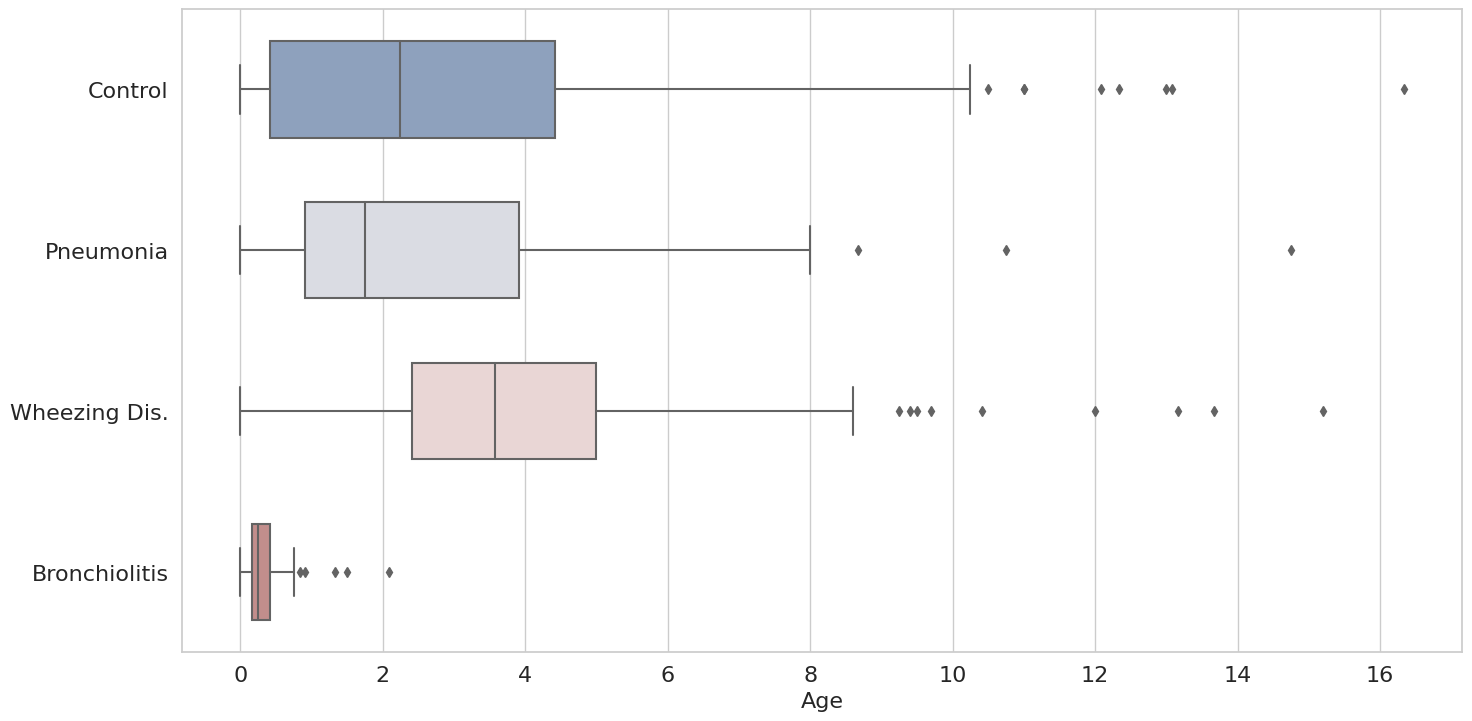

In [42]:
get_box_plot(selected, "age")

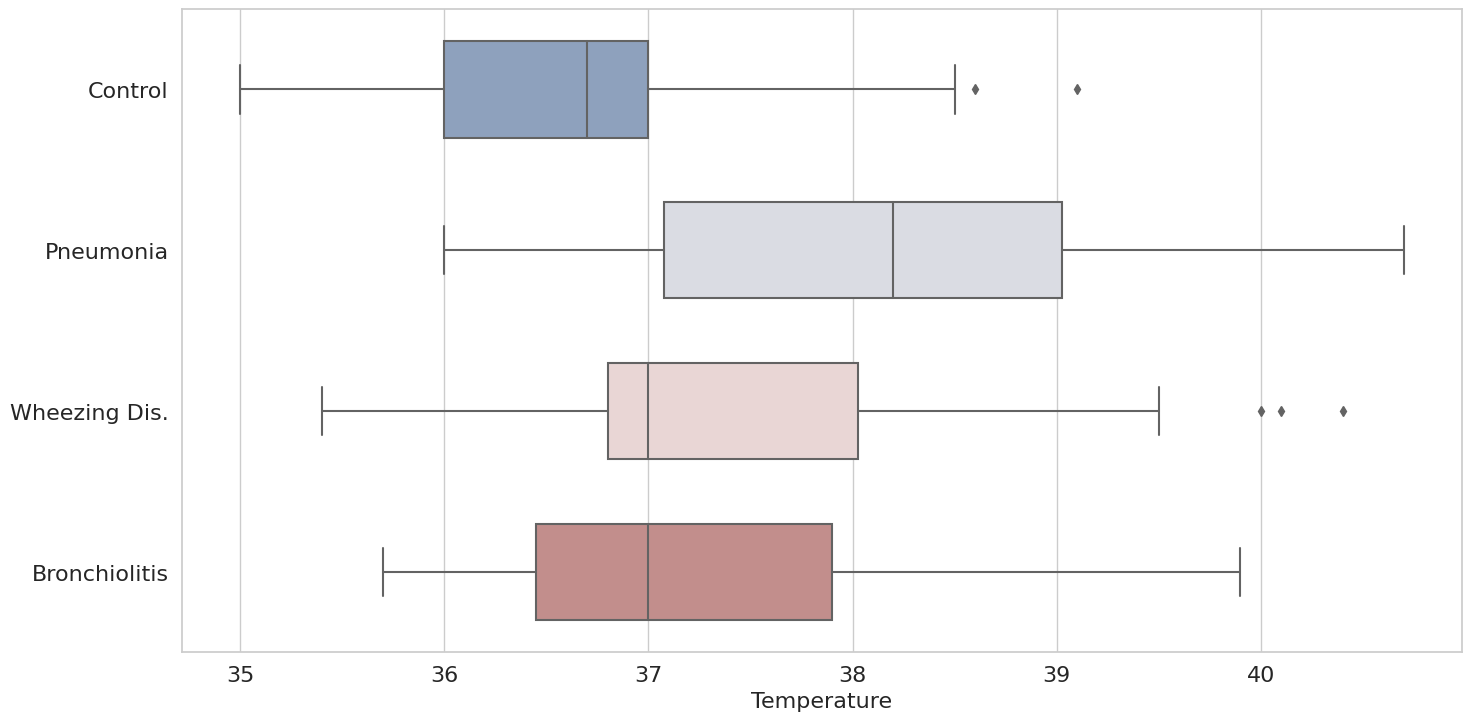

In [43]:
get_box_plot(selected, "temperature")

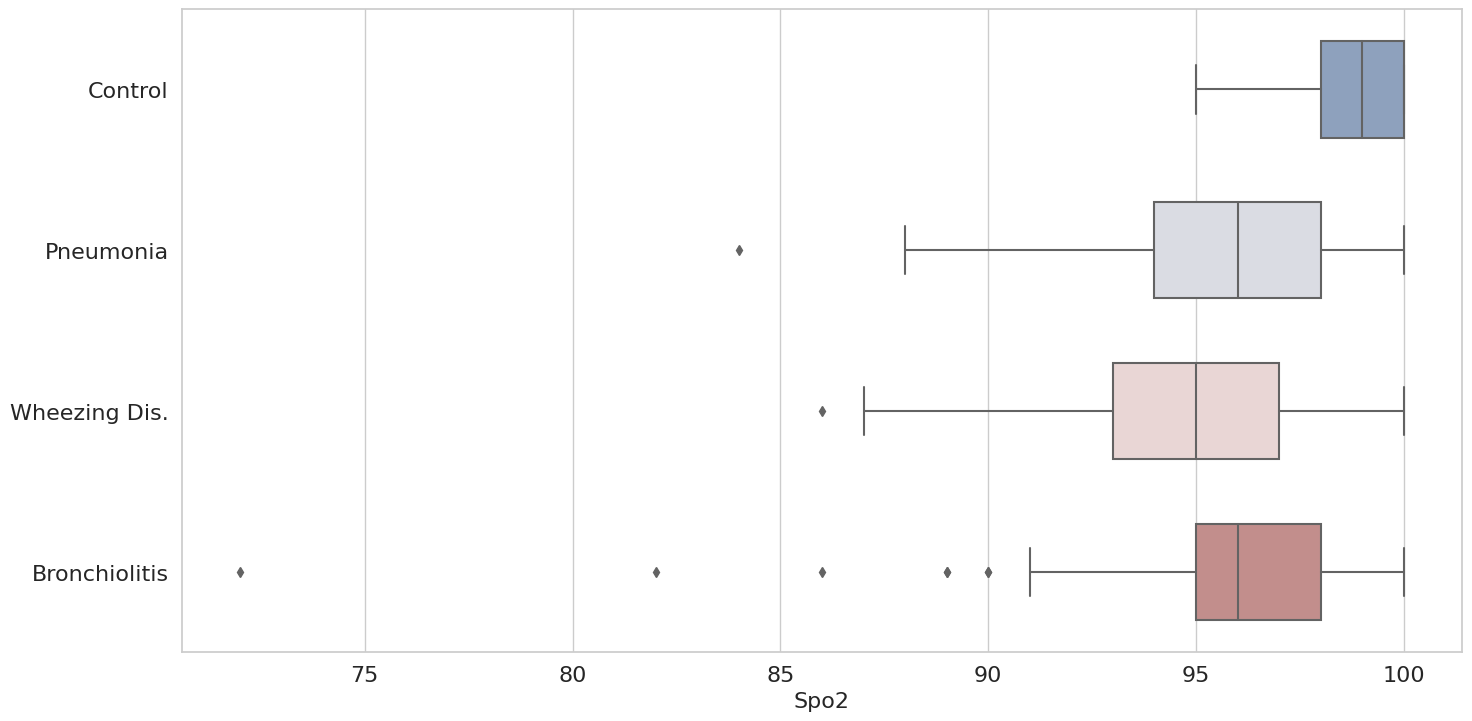

In [44]:
get_box_plot(selected, "spo2")

## Model Receptive Field

In [45]:
# [filter size, stride, padding]
#Assume the two dimensions are the same
#Each kernel requires the following parameters:
# - k_i: kernel size
# - s_i: stride
# - p_i: padding (if padding is uneven, right padding will higher than left padding; "SAME" option in tensorflow)
# 
#Each layer i requires the following parameters to be fully represented: 
# - n_i: number of feature (data layer has n_1 = imagesize )
# - j_i: distance (projected to image pixel distance) between center of two adjacent features
# - r_i: receptive field of a feature in layer i
# - start_i: position of the first feature's receptive field in layer i (idx start from 0, negative means the center fall into padding)

import math
convnet =   [[3,1,1],[2,2,0],[3,1,1],[2,2,0],[3,1,1],[2,2,0],[3,1,1],[2,2,0],[3,1,1],[1,1,0]]
layer_names = ['conv1','pool1','conv2','pool2','conv3','pool3','conv4','pool4','conv5','pool5']
imsize = 313


def outFromIn(conv, layerIn):
    n_in = layerIn[0]
    j_in = layerIn[1]
    r_in = layerIn[2]
    start_in = layerIn[3]
    k = conv[0]
    s = conv[1]
    p = conv[2]

    n_out = math.floor((n_in - k + 2*p)/s) + 1
    actualP = (n_out-1)*s - n_in + k 
    pR = math.ceil(actualP/2)
    pL = math.floor(actualP/2)

    j_out = j_in * s
    r_out = r_in + (k - 1)*j_in
    start_out = start_in + ((k-1)/2 - pL)*j_in
    return n_out, j_out, r_out, start_out
  
    
def printLayer(layer, layer_name):
    print(layer_name + ":")
    print("\t n features: %s \n \t jump: %s \n \t receptive size: %s \t start: %s " % (layer[0], layer[1], layer[2], layer[3]))

    
layerInfos = []
#first layer is the data layer (image) with n_0 = image size; j_0 = 1; r_0 = 1; and start_0 = 0.5
print("-------Net summary------")
currentLayer = [imsize, 1, 1, 0.5]
printLayer(currentLayer, "input image")
for i in range(len(convnet)):
    currentLayer = outFromIn(convnet[i], currentLayer)
    layerInfos.append(currentLayer)
    printLayer(currentLayer, layer_names[i])
print("------------------------")
layer_name = 'pool5'
layer_idx = layer_names.index(layer_name)
idx_x = 0
idx_y = 0

n = layerInfos[layer_idx][0]
j = layerInfos[layer_idx][1]
r = layerInfos[layer_idx][2]
start = layerInfos[layer_idx][3]
assert(idx_x < n)
assert(idx_y < n)

print("receptive field: (%s, %s)" % (r, r))
print("center: (%s, %s)" % (start+idx_x*j, start+idx_y*j))

-------Net summary------
input image:
	 n features: 313 
 	 jump: 1 
 	 receptive size: 1 	 start: 0.5 
conv1:
	 n features: 313 
 	 jump: 1 
 	 receptive size: 3 	 start: 0.5 
pool1:
	 n features: 156 
 	 jump: 2 
 	 receptive size: 4 	 start: 2.0 
conv2:
	 n features: 156 
 	 jump: 2 
 	 receptive size: 8 	 start: 2.0 
pool2:
	 n features: 78 
 	 jump: 4 
 	 receptive size: 10 	 start: 3.0 
conv3:
	 n features: 78 
 	 jump: 4 
 	 receptive size: 18 	 start: 3.0 
pool3:
	 n features: 39 
 	 jump: 8 
 	 receptive size: 22 	 start: 5.0 
conv4:
	 n features: 39 
 	 jump: 8 
 	 receptive size: 38 	 start: 5.0 
pool4:
	 n features: 19 
 	 jump: 16 
 	 receptive size: 46 	 start: 17.0 
conv5:
	 n features: 19 
 	 jump: 16 
 	 receptive size: 78 	 start: 17.0 
pool5:
	 n features: 19 
 	 jump: 16 
 	 receptive size: 78 	 start: 17.0 
------------------------
receptive field: (78, 78)
center: (17.0, 17.0)
